In [1]:
import numpy as np
import pandas as pd 

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# EDA

## First Step 

The first step in our data analysis is to read in the input data files into dataframes. We first load in the train dataset and then map class labels to the images.

In [4]:
# load in the training data and use the names.csv to map the correct label
anno_train = pd.read_csv('/Users/smallina/Desktop/Stanford/Data/anno_train.csv', header=None)
names = pd.read_csv('/Users/smallina/Desktop/Stanford/Data/names.csv', header=None)

label_to_name = names[0].to_dict()  
anno_train.columns = ['image', 'x1', 'y1', 'x2', 'y2', 'label']  
anno_train['car_model'] = anno_train['label'].map(label_to_name) 
train_df = anno_train[['image', 'x1', 'y1', 'x2', 'y2', 'car_model']] # contains information about the training dataset

# sanity check to make sure the data is read in correctly
print(train_df.head())

       image   x1   y1    x2    y2                      car_model
0  00001.jpg   39  116   569   375             Audi R8 Coupe 2012
1  00002.jpg   36  116   868   587           Acura TL Type-S 2008
2  00003.jpg   85  109   601   381        Dodge Magnum Wagon 2008
3  00004.jpg  621  393  1484  1096     Hyundai Elantra Sedan 2007
4  00005.jpg   14   36   133    99  Ford Mustang Convertible 2007


Load in the test dataset and map labels to the test dataset

In [6]:
anno_test = pd.read_csv('/Users/smallina/Desktop/Stanford/Data/anno_test.csv', header=None)
anno_test.columns = ['image', 'x1', 'y1', 'x2', 'y2', 'label']
anno_test['car_model'] = anno_test['label'].map(label_to_name)
test_df = anno_test[['image', 'x1', 'y1', 'x2', 'y2', 'car_model']] # contains information about the test dataset 

# sanity check to make sure the data is read in correctly
print(test_df.head())

       image   x1   y1   x2   y2                      car_model
0  00001.jpg   30   52  246  147      Suzuki Kizashi Sedan 2012
1  00002.jpg  100   19  576  203  Ferrari 458 Italia Coupe 2012
2  00003.jpg   51  105  968  659         Jeep Wrangler SUV 2012
3  00004.jpg   67   84  581  407      Toyota Corolla Sedan 2012
4  00005.jpg  140  151  593  339        Toyota Sequoia SUV 2012


Combine the two datasets into one to make data analysis easier

In [7]:
train_df['dataset'] = 'train' # add column variable to identify which set the image is from 
test_df['dataset'] = 'test'

# combine the dataset to perform analyses
combined_df = pd.concat([train_df[['image', 'x1', 'y1', 'x2', 'y2', 'car_model', 'dataset']],
                         test_df[['image', 'x1', 'y1', 'x2', 'y2', 'car_model', 'dataset']]], ignore_index=True)

# sanity check to make sure the data is combined correctly
combined_df.head()

,image,x1,y1,x2,y2,car_model,dataset
0,00001.jpg,39,116,569,375,Audi R8 Coupe 2012,train
1,00002.jpg,36,116,868,587,Acura TL Type-S 2008,train
2,00003.jpg,85,109,601,381,Dodge Magnum Wagon 2008,train
3,00004.jpg,621,393,1484,1096,Hyundai Elantra Sedan 2007,train
4,00005.jpg,14,36,133,99,Ford Mustang Convertible 2007,train


The second step in a classification problem is to figure out how many members there are in each class. This step is vital because it determines whether or not we have class imbalance. Which in our case we do because the number of times every label occurs is not the same.

In [8]:
car_model_distribution = combined_df['car_model'].value_counts() # count up the number of times the label appears in the dataset
car_model_distribution.head(10) # first 10 entries

car_model
GMC Yukon Hybrid SUV 2012                          136
Chrysler Crossfire Convertible 2008                 97
Mercedes-Benz C-Class Sedan 2012                    96
Nissan Leaf Hatchback 2012                          95
Chevrolet Corvette Ron Fellows Edition Z06 2007     93
Jeep Patriot SUV 2012                               93
Plymouth Neon Coupe 1999                            92
Volkswagen Beetle Hatchback 2012                    92
Audi S5 Convertible 2012                            92
Bentley Continental Flying Spur Sedan 2007          92
Name: count, dtype: int64

In [9]:
car_model_distribution.tail(10) # last 10 entries

car_model
Ferrari FF Coupe 2012                67
Aston Martin Virage Coupe 2012       66
Isuzu Ascender SUV 2008              65
Bugatti Veyron 16.4 Coupe 2009       65
Acura TL Sedan 2012                  64
Rolls-Royce Ghost Sedan 2012         61
Chevrolet Avalanche Crew Cab 2012    59
Mazda Tribute SUV 2011               58
FIAT 500 Convertible 2012            55
Hyundai Genesis Sedan 2012           48
Name: count, dtype: int64

The next step in the analysis is to determine the average dimensions of the bounding box. This will help use see how average car size is compared to the rest of the photo. The average bounding box size for the images is 574 by 309.

In [10]:
combined_df['width'] = combined_df['x2'] - combined_df['x1'] # determine height and width
combined_df['height'] = combined_df['y2'] - combined_df['y1']
average_width = combined_df['width'].mean() # get the averages of the column
average_height = combined_df['height'].mean()

average_width, average_height 

(573.8356502934816, 308.62255174544333)

We then proceeded to check if any of the bounding boxes were outliers. This would be when the majority of the car makes up the photo. We were also interested in which cars images were outliers as well.

In [11]:
q1_width = combined_df['width'].quantile(0.25)
q3_width = combined_df['width'].quantile(0.75)
iqr_width = q3_width - q1_width # calculate iqr range using 75th percentile - 25th percentile 

q1_height = combined_df['height'].quantile(0.25)
q3_height = combined_df['height'].quantile(0.75)
iqr_height = q3_height - q1_height

width_outlier_min = q1_width - 1.5 * iqr_width # determine the bounderies of non outliers values
width_outlier_max = q3_width + 1.5 * iqr_width
height_outlier_min = q1_height - 1.5 * iqr_height
height_outlier_max = q3_height + 1.5 * iqr_height

outliers = combined_df[(combined_df['width'] < width_outlier_min) | 
                       (combined_df['width'] > width_outlier_max) |
                       (combined_df['height'] < height_outlier_min) | 
                       (combined_df['height'] > height_outlier_max)] # find the outliers which have at least one value that is greater than the standard car image dimensions

num_outliers = outliers.shape[0] # number of outliers

num_outliers, outliers.head() # print the first few rows of the outliers

(1246,
         image   x1   y1    x2    y2                   car_model dataset  \
 3   00004.jpg  621  393  1484  1096  Hyundai Elantra Sedan 2007   train   
 8   00009.jpg   20  126  1269   771  Nissan Leaf Hatchback 2012   train   
 21  00022.jpg  212  538  1893  1131             BMW X3 SUV 2012   train   
 28  00029.jpg   28  139  1564  1126     Suzuki Aerio Sedan 2007   train   
 53  00054.jpg   58  562  1528  1081  Eagle Talon Hatchback 1998   train   
 
     width  height  
 3     863     703  
 8    1249     645  
 21   1681     593  
 28   1536     987  
 53   1470     519  )

We were also interested in teh distribution of the dimension of the data so we plotted the distribution to see where a majority of the data's dimensions lied. 

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


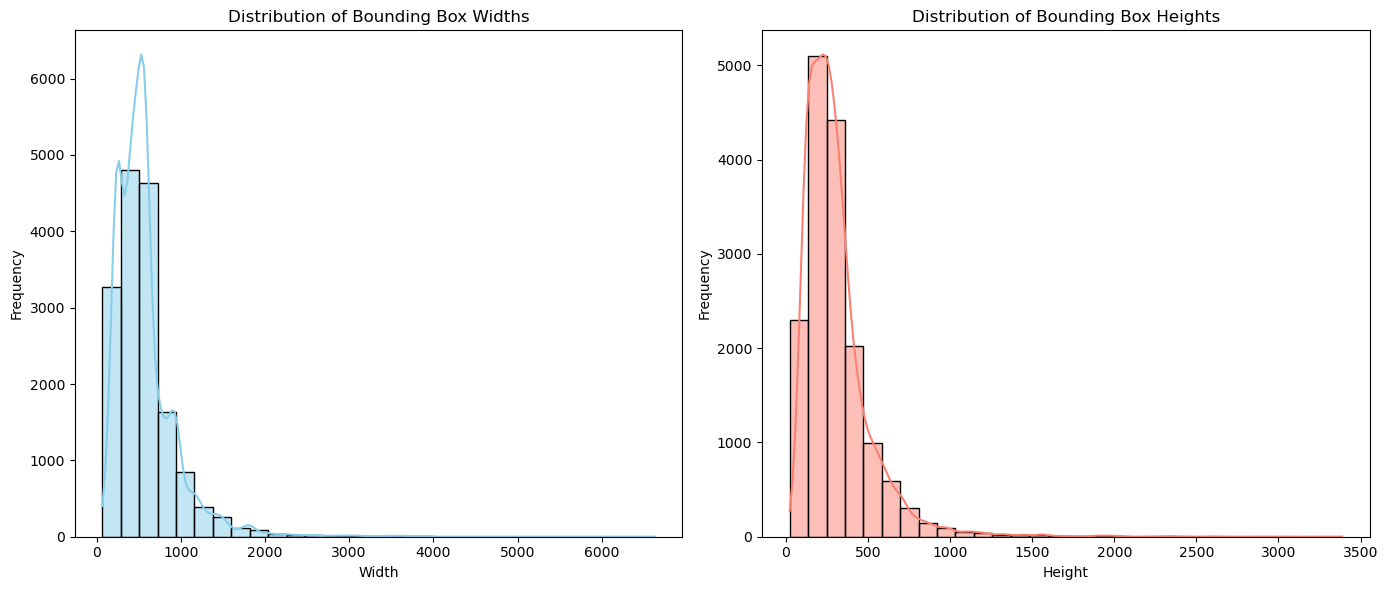

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(combined_df['width'], bins=30, kde=True, color="skyblue")
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(combined_df['height'], bins=30, kde=True, color="salmon")
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Better visualization to see the outliers from the dataset. Split by train and test datasets. 

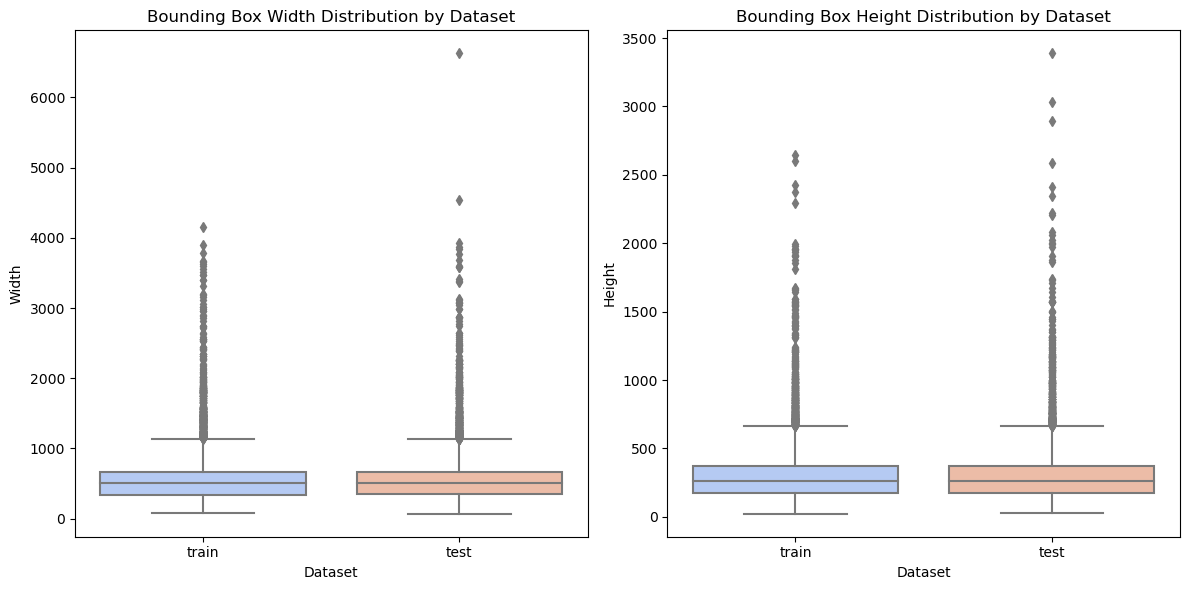

In [24]:
train_model_distribution = combined_df[combined_df['dataset'] == 'train']['car_model'].value_counts()
test_model_distribution = combined_df[combined_df['dataset'] == 'test']['car_model'].value_counts()

train_model_pct = train_model_distribution / train_model_distribution.sum() * 100
test_model_pct = test_model_distribution / test_model_distribution.sum() * 100

unique_train_models = set(combined_df[combined_df['dataset'] == 'train']['car_model'].unique())
unique_test_models = set(combined_df[combined_df['dataset'] == 'test']['car_model'].unique())



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=combined_df, x='dataset', y='width', palette="coolwarm")
plt.title('Bounding Box Width Distribution by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Width')

plt.subplot(1, 2, 2)
sns.boxplot(data=combined_df, x='dataset', y='height', palette="coolwarm")
plt.title('Bounding Box Height Distribution by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Height')

plt.tight_layout()
plt.show()




We wanted to check to see if all the car types are in both train and test dataset.

In [23]:
missing_test_models = unique_train_models - unique_test_models # check to see if there are any types of cars that appear on in train but not in test
len(missing_test_models), list(missing_test_models)[:5]

(0, [])

After getting a better understanding of the distribution of the data, we were interested in finding out the distribution of car makers as well as the years of the cars.

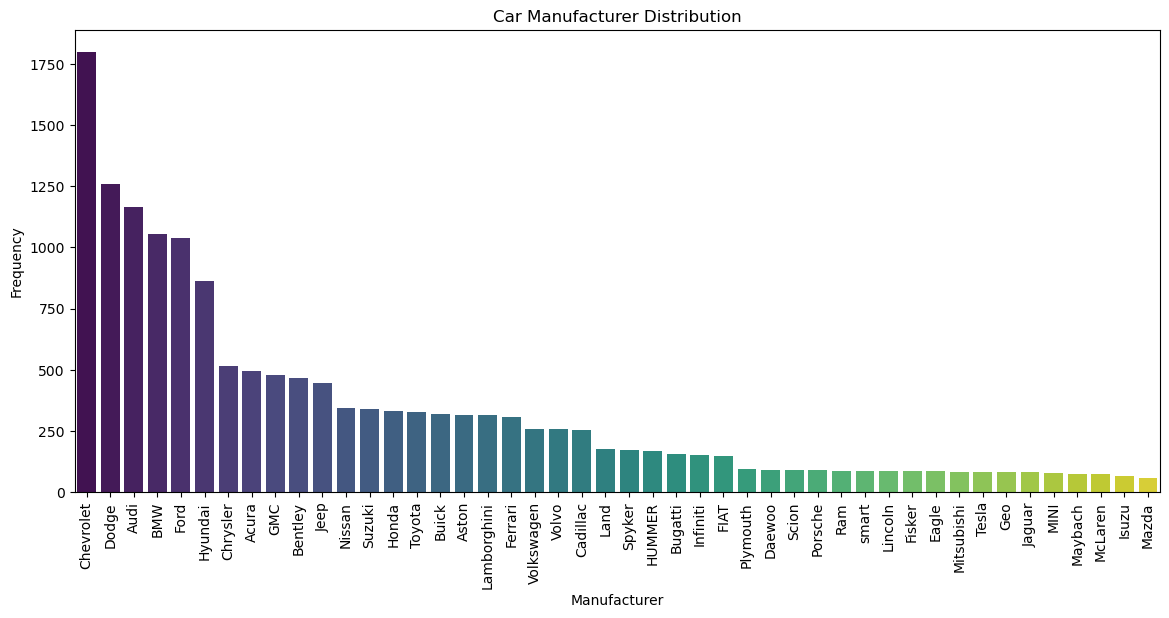

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


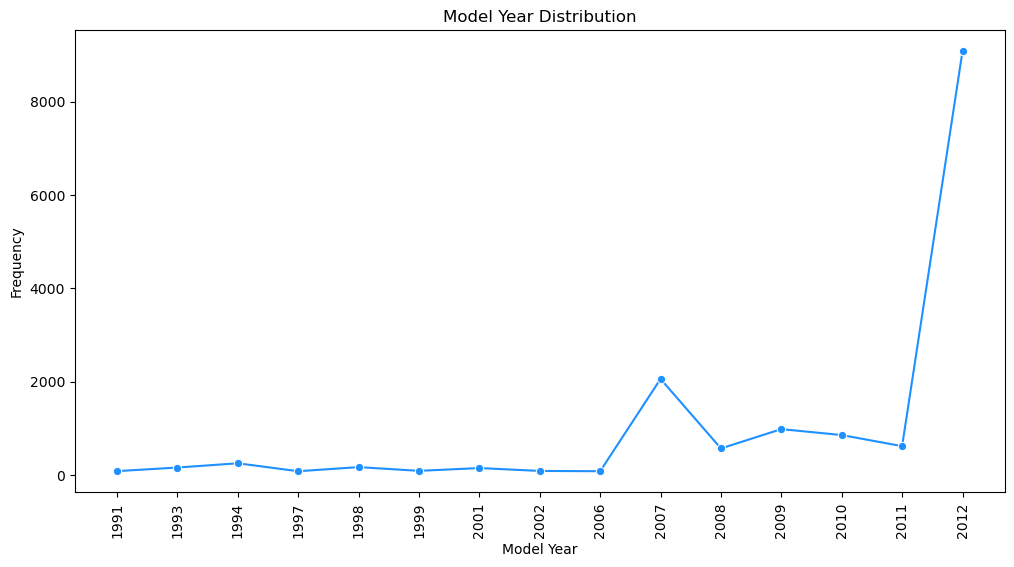

In [19]:

combined_df[['manufacturer', 'model_year']] = combined_df['car_model'].str.extract(r'(^[A-Za-z]+)\s.*(\d{4})$') # extracted the manufacturer and year

manufacturer_distribution = combined_df['manufacturer'].value_counts() # counted up the number of times manufacturer came up in the dataset

year_distribution = combined_df['model_year'].value_counts().sort_index() # # counted up the number of times model year came up in the dataset

plt.figure(figsize=(14, 6))
sns.barplot(x=manufacturer_distribution.index, y=manufacturer_distribution.values, palette="viridis")
plt.title('Car Manufacturer Distribution')
plt.xlabel('Manufacturer')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=year_distribution.index, y=year_distribution.values, marker='o', color="dodgerblue")
plt.title('Model Year Distribution')
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

After plotting the manufacturer and model_year we interested to see if there a trend in people buying a certain manufacturer over time.

<Figure size 1400x800 with 0 Axes>

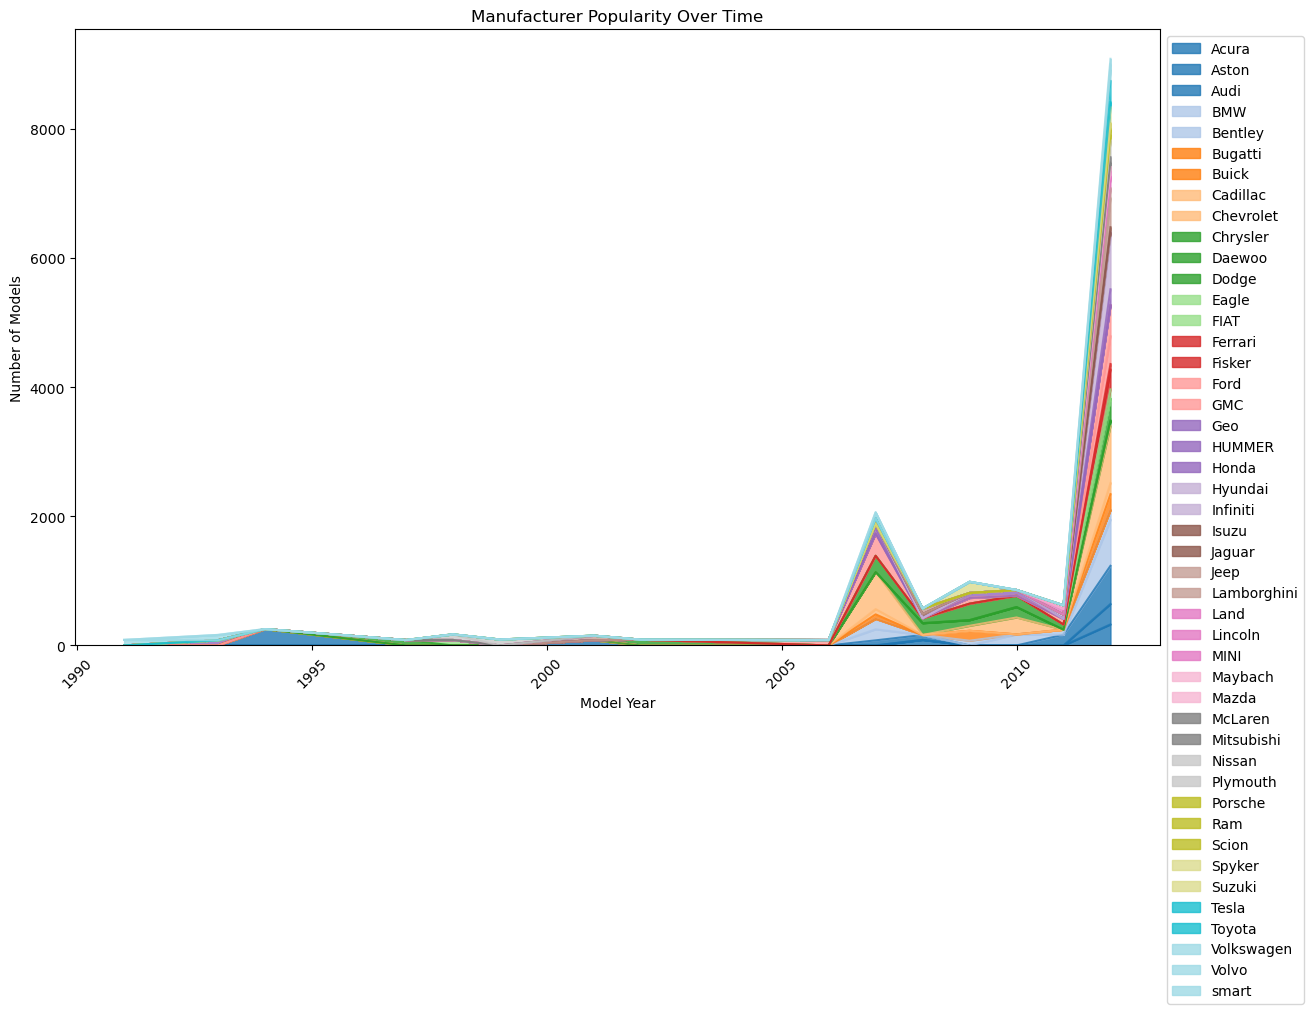

In [15]:
manufacturer_year_counts = combined_df.groupby(['manufacturer', 'model_year']).size().reset_index(name='count') # group by the two variables that we are interested in

manufacturer_year_counts['model_year'] = pd.to_numeric(manufacturer_year_counts['model_year'], errors='coerce') # convert model year into numeric to avoid issues
manufacturer_year_counts = manufacturer_year_counts.dropna(subset=['model_year']) 

manufacturer_year_pivot = manufacturer_year_counts.pivot(index='model_year', columns='manufacturer', values='count').fillna(0)

plt.figure(figsize=(14, 8))
manufacturer_year_pivot.plot(kind='area', stacked=True, figsize=(14, 8), cmap='tab20', alpha=0.8)
plt.title('Manufacturer Popularity Over Time')
plt.xlabel('Model Year')
plt.ylabel('Number of Models')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

We wanted to see if we could accurately create a bound box for the car based on the information given

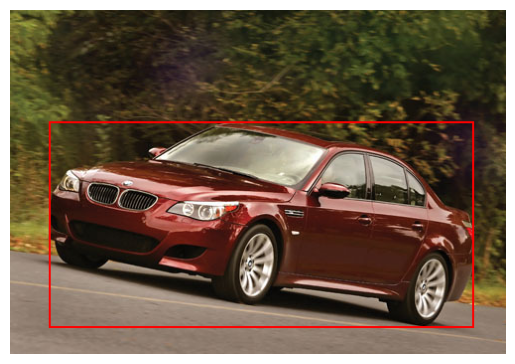

In [25]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def show_image_with_bbox(image_path, x1, y1, x2, y2):
    try:
        # Open the image
        image = Image.open(image_path)
        # Create a draw object
        draw = ImageDraw.Draw(image)
        # Draw the bounding box on the image
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        # Display the image
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print("Image not found:", image_path)

sample = combined_df.sample(1).iloc[0]
image_filename = sample['image']
image_path = f'/Users/smallina/Desktop/Stanford/Data/cars_train/{image_filename}'
x1, y1, x2, y2 = sample['x1'], sample['y1'], sample['x2'], sample['y2']
show_image_with_bbox(image_path, x1, y1, x2, y2)